In [1]:
%load_ext autoreload
%autoreload 2
# from gtd2d import gtd2d
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import open3d as o3d
import matplotlib
import matplotlib.cm as cm
from tqdm import tqdm
import pickle

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
path = "C:/Users/schiavaz/lava-nc/depth/"
dataset = "data/esim_data/line_top/"

In [3]:
with open(path + 'results/result.pkl', 'rb') as f:
    out = pickle.load(f)

In [4]:
# runner.vel_input_buffer

In [5]:
# out = runner.run()

In [6]:
raw_depths = out["raw_depths"]

In [7]:
out["times"].shape

(2000,)

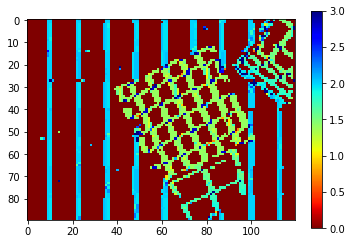

In [8]:
m = plt.imshow(raw_depths[100:200].sum(axis=0), interpolation="none", cmap="jet_r", vmax=3)
plt.colorbar(m)

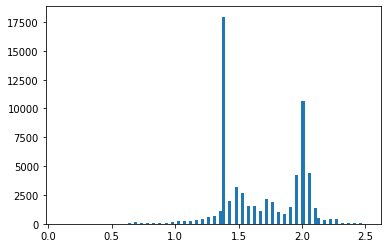

In [9]:
plt.hist(raw_depths.flatten(), 100, range=(0.1, 2.5));

In [10]:
flow_u = out["flow_u"]
flow_v = out["flow_v"]

In [11]:
idx = 3
U = flow_u[idx:].sum(axis=0)
V = flow_v[idx:].sum(axis=0)
m = np.sqrt(U**2 + V**2)

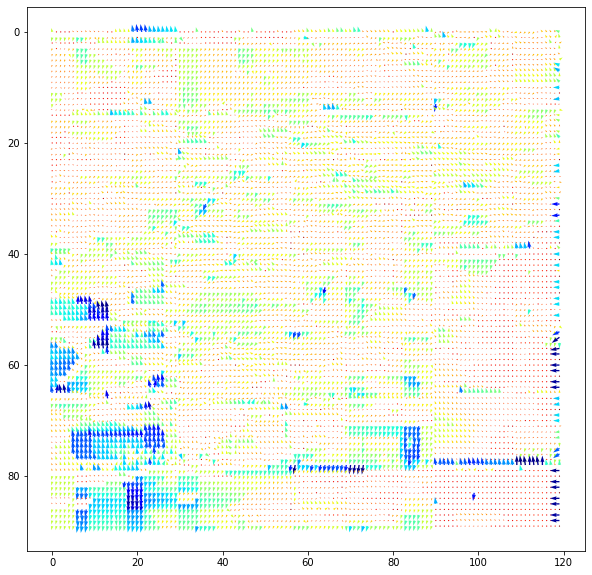

In [12]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U[::1, ::1], V[::1, ::1], m[::1, ::1], cmap="jet_r")
plt.gca().invert_yaxis()

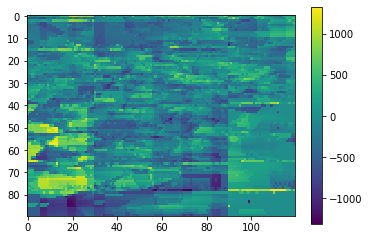

In [13]:
m = plt.imshow(V, interpolation="none")
plt.colorbar(m)

In [14]:
poses = np.loadtxt(path + dataset + "groundtruth.txt")
calib = np.loadtxt(path + dataset + "calib.txt")
calib[0] = 200
calib[1] = 200
calib[2] = 120
calib[3] = 90
calib = calib / 2

In [30]:
raw_depths = out["mean_depths"][::1]
times = out["times"][::1]

In [31]:
def _image2pointcloud(d, v_range=None):
    points = []
    for x in range(d.shape[1]):
        for y in range(d.shape[0]):
            if np.isnan(d[y, x]):
                continue
            if v_range != None:
                if v_range[0] > d[y, x] or d[y, x] > v_range[1]:
                    continue
            points.append([x, y, d[y, x]])
    return np.array(points)

In [32]:
def project3d(points, calib, pose):
    K = np.array([
        [calib[0], 0, calib[2]],
        [0, calib[1], calib[3]],
        [0, 0, 1]
    ])

    t = pose[1:4].reshape(3, 1)
    q = pose[4:]

    r = R.from_quat(q)
    r_m = r.as_matrix()

    K_b = np.block([
        [K, np.zeros((3, 1))],
        [np.zeros((1, 3)), 1]
    ])
    rt_b = np.block([
        [r_m, t],
        [np.zeros((1, 3)), 1]
    ])

    proj = []
    for p in points:
        if p[2] == 0:
            continue
        po = np.array([p[0], p[1], 1, 1 / p[2]])
        test = p[2] * np.linalg.inv(K_b @ rt_b) @ po
        proj.append(test.transpose())

    proj = np.array(proj)
    return proj

In [33]:
projected_points = np.zeros((1, 4))
ps = []
p_init = poses[0]
for i, d in enumerate(tqdm(raw_depths)):
    points = _image2pointcloud(d)

    idx = np.searchsorted(poses[:, 0], times[i])
#     print(times[i])
    p0 = poses[idx - 1]
    p1 = poses[idx]
    y = (times[i] - p0[0]) / (p1[0] - p0[0])
    p = (p0 * (1 - y) + p1 * (y))
    p[1:4] = p[1:4].reshape(1, 3) @ np.diag([-1, 1, 1])
#     p = poses[0]
#     print("p0: {},\np1:{},\np:{}".format(p0[:4], p1[:4], p[:4]))
    ps.append([p[2], p[3], p[1]])
    
    proj = project3d(points, calib, p)
    if proj.size == 0:
        continue
    projected_points = np.concatenate((projected_points, proj))

100%|█████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.68it/s]


In [34]:
def points_to_open3d_pointcloud(points, cmap="jet_r", z=2):

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    minima = min(points[:, z])
    maxima = max(points[:, z])
    print(minima)
    print(maxima)
    print("---")

    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = mapper.to_rgba(points[:, z])[:,:3]
    print(colors.shape)

    pcd.colors = o3d.utility.Vector3dVector(colors)

    return pcd

In [35]:
projected_points

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.2603467 , -0.13338115, -0.60449681,  1.        ],
       [-0.53283011, -0.31938017, -0.18599902,  1.        ],
       ...,
       [ 0.24664239, -1.19078557, -1.99948946,  1.        ],
       [ 0.24664239, -1.21078047, -1.99948946,  1.        ],
       [ 0.24664239, -1.23077536, -1.99948946,  1.        ]])

In [40]:
proj = projected_points[projected_points[:,2] > -3]
pcd = points_to_open3d_pointcloud(proj[:,:3], cmap="jet", z=2)

o3d.visualization.draw_geometries([pcd])

-2.8364850431355
0.0
---
(20010, 3)
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [37]:
pcd_d = pcd.random_down_sample(1.0)
pcd_f, l = pcd_d.remove_radius_outlier(nb_points=10, radius=0.05)
# pcd_f, l = pcd_d.remove_statistical_outlier(nb_neighbors=30, std_ratio=0.2, print_progress=True)

In [38]:
pcd_b = pcd_f.voxel_down_sample(voxel_size=0.02)

In [39]:
o3d.visualization.draw_geometries([pcd_f])

In [25]:
ps = np.array(ps)
ps_b = np.copy(ps)

In [26]:
ps_b[:, 0] += 3

In [27]:
# proj = projected_points[projected_points[:,2] > -3]
ps_pcd = points_to_open3d_pointcloud(ps_b, cmap="spring", z=2)

o3d.visualization.draw_geometries([pcd_b, ps_pcd])

-0.30662707770819053
0.6244566279166551
---
(2000, 3)


In [28]:
median_depths = out["median_depths"]

In [29]:
idx = 120
med_m = np.ma.masked_where(median_depths[idx]==0, median_depths[idx])
m = plt.imshow(med_m, interpolation="none", cmap="jet_r", vmax=3)
plt.colorbar(m)

TypeError: 'NoneType' object is not subscriptable